In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

In [3]:
import os # 모델 저장할 폴더가 있는지 여부와 폴더 생성
import numpy as np
import pandas as pd # get_dummies(원핫인코딩), crosstab
import seaborn as sns # iris 데이터(데이터프레임) 가져오기
from sklearn import datasets # iris 데이터(X, y) 가져오기
from sklearn.preprocessing import LabelEncoder # 라벨인코더
from tensorflow.keras.utils import to_categorical # 원핫인코딩 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

- 데이터 셋 생성(seaborn) & 전처리
    X, y(setosa,versicolor,virginica라벨인코딩-원핫코딩)분리 -> train과 test셋 분리(8:2)
- 모델 구성(입력4 -> 출력3, layer5: 4->64->128->50->30->3) 
- 모델 학습과정 설정
- 모델 학습(Earlystopping, ModelCheckpoint추가)
- 모델평가(시각화, 현재모델과 저장된 최고의 모델 평가, 교차표==혼동행렬)
- 모델예측/저장

# 1. 데이터 셋 생성(seaborn) & 전처리

In [4]:
iris = sns.load_dataset('iris')
iris.loc[::50]

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
50,7.0,3.2,4.7,1.4,versicolor
100,6.3,3.3,6.0,2.5,virginica


In [5]:
# 문자변수 원핫인코딩 방법1
encoder = LabelEncoder()
iris['y'] = encoder.fit_transform(iris['species'])
display(iris.loc[::50])
# utils.to_categorical(iris['species'])[:5]
# to_categorical을 하려면 숫자필드로 라벨인코딩먼저
to_categorical(iris['y'])[::50]

,sepal_length,sepal_width,petal_length,petal_width,species,y
0,5.1,3.5,1.4,0.2,setosa,0
50,7.0,3.2,4.7,1.4,versicolor,1
100,6.3,3.3,6.0,2.5,virginica,2


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [6]:
# 문자변수 원핫인코딩 방법2
pd.get_dummies(iris.species)[::50]

,setosa,versicolor,virginica
0,1,0,0
50,0,1,0
100,0,0,1


In [7]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# 독립변수와 종속변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()
iris_y = iris.iloc[:, -1]
iris_Y = pd.get_dummies(iris_y).values
# 훈련셋 : 테스트셋 = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y,
                                                   test_size=0.2,
                                                   stratify=iris_Y, # 층화추출
                                                   random_state=4) 
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

In [9]:
# 층화 추출했는지 확인 
pd.Series(np.argmax(Y_train, axis=1)).value_counts()

0    40
1    40
2    40
dtype: int64

In [10]:
pd.Series(np.argmax(Y_test, axis=1)).value_counts()

1    10
2    10
0    10
dtype: int64

# 2. 모델 구성
(입력4 -> 출력3, layer5: 4->64->128->50->30->3) 

In [8]:
model = Sequential()
model.add(Dense(units=64, input_dim=4, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                1530      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0

# 3. 모델 학습과정 설정

In [9]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# 4. 모델 학습
(Earlystopping, ModelCheckpoint추가)

In [10]:
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder \
        + 'iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
# 콜백객체
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy', # 모니터링 지표:loss, val_loss, accuracy
                    save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=1) # 로그 출력 여부
earlystopping = EarlyStopping(patience=40)# monitor='val_loss' 기본값
hist=model.fit(X_train,Y_train,batch_size=40,
               epochs=200,
               validation_split=0.2,
               callbacks=[checkpoint,earlystopping])

Epoch 1/200
1/3 [=========>....................] - ETA: 1s - loss: 1.3322 - accuracy: 0.2750
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to ./model\iris-001-loss1.0991-acc0.2500.h5
3/3 [==============================] - 1s 130ms/step - loss: 1.2683 - accuracy: 0.3125 - val_loss: 1.0991 - val_accuracy: 0.2500
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 1.0177 - accuracy: 0.5500
Epoch 2: val_accuracy did not improve from 0.25000
3/3 [==============================] - 0s 16ms/step - loss: 1.0602 - accuracy: 0.5000 - val_loss: 1.0775 - val_accuracy: 0.2500
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 1.0599 - accuracy: 0.4000
Epoch 3: val_accuracy did not improve from 0.25000
3/3 [==============================] - 0s 16ms/step - loss: 1.0552 - accuracy: 0.4062 - val_loss: 1.0200 - val_accuracy: 0.2500
Epoch 4/200
1/3 [=========>....................] - ETA: 0s - loss: 0.9991 - accuracy: 0.5000
Epoch 4: val_accuracy improved 

1/3 [=========>....................] - ETA: 0s - loss: 0.2848 - accuracy: 0.8750
Epoch 30: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 14ms/step - loss: 0.2524 - accuracy: 0.8854 - val_loss: 0.0766 - val_accuracy: 1.0000
Epoch 31/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1532 - accuracy: 0.9750
Epoch 31: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 14ms/step - loss: 0.1952 - accuracy: 0.9271 - val_loss: 0.0719 - val_accuracy: 1.0000
Epoch 32/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2958 - accuracy: 0.8750
Epoch 32: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 15ms/step - loss: 0.2642 - accuracy: 0.8750 - val_loss: 0.0708 - val_accuracy: 1.0000
Epoch 33/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1540 - accuracy: 0.9250
Epoch 33: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 15m

Epoch 60/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0435 - accuracy: 1.0000
Epoch 60: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 15ms/step - loss: 0.1391 - accuracy: 0.9375 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 61/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2641 - accuracy: 0.9250
Epoch 61: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 15ms/step - loss: 0.1601 - accuracy: 0.9375 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 62/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0269 - accuracy: 1.0000
Epoch 62: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 14ms/step - loss: 0.0988 - accuracy: 0.9792 - val_loss: 0.0348 - val_accuracy: 1.0000
Epoch 63/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0991 - accuracy: 0.9750
Epoch 63: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 90/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0430 - accuracy: 1.0000
Epoch 90: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 14ms/step - loss: 0.0699 - accuracy: 0.9896 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 91/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0416 - accuracy: 1.0000
Epoch 91: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.0810 - accuracy: 0.9792 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 92/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1539 - accuracy: 0.9750
Epoch 92: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 14ms/step - loss: 0.1111 - accuracy: 0.9792 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 93/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1612 - accuracy: 0.9250
Epoch 93: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 120/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0832 - accuracy: 0.9750
Epoch 120: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 14ms/step - loss: 0.0865 - accuracy: 0.9792 - val_loss: 0.0576 - val_accuracy: 0.9583
Epoch 121/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - accuracy: 1.0000
Epoch 121: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 15ms/step - loss: 0.0834 - accuracy: 0.9688 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 122/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - accuracy: 1.0000
Epoch 122: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 15ms/step - loss: 0.0601 - accuracy: 0.9896 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 123/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0667 - accuracy: 0.9750
Epoch 123: val_accuracy did not improve from 1.00000
3/3 [===================

# 5. 모델 평가
(시각화, 현재모델과 저장된 최고의 모델 평가, 교차표==혼동행렬)

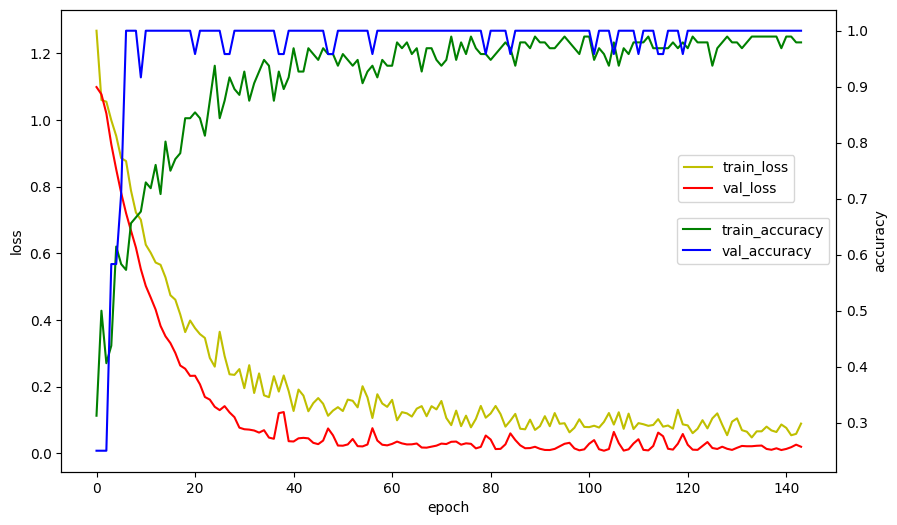

In [11]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [12]:
# 모델 평가
loss_and_acc =model.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:0.1553, accuracy:0.9333


In [13]:
model1 = load_model('model/iris-007-loss0.7205-acc1.0000.h5')
loss_and_acc1 =model1.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

loss:0.7289, accuracy:1.0000


In [14]:
model2 = load_model('model/iris-005-loss0.7852-acc1.0000.h5')
loss_and_acc2 =model2.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc2[0]:.4f}, accuracy:{loss_and_acc2[1]:.4f}')

loss:0.7916, accuracy:0.9333
